# The Most Expensive Metro Stations in Moscow 
Based off of the apartments listings from [realto.ru](http://www.realto.ru/base/flat_sale/?SecLodg_step=1&filter%5BRegion%5D=moscow) I will try to show through a linear regression where the most expensive metro stations are.

## Libraries needed

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scrapy
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import requests
import json

## Web scrapping
The data from [realto.ru](http://www.realto.ru/base/flat_sale/?SecLodg_step=1&filter%5BRegion%5D=moscow) that will be used is the apartment price in Rubles, the nearest metro station, the number of rooms, the size of the apartment and the floor it's located on. The website has the most recent 1500 listings available.  

In [3]:
class PostsSpider(scrapy.Spider):
    name="ma"    
    start_urls=[
        'http://www.realto.ru/base/flat_sale/?SecLodg_step='+str(x)+'&filter%5BRegion%5D=moscow'
        for x in range(1,55)    
    ]     
      def parse(self, response):
        for row in response.css('tr.row_base'):
            yield {
                'price':row.css('td:nth-child(1) > small:nth-child(2)::text').get(),
                'metro':row.css('td:nth-child(3)::text').get(),
                'rooms':row.css('td:nth-child(4)::text').get(),
                'size':row.css('td:nth-child(5) > span:nth-child(1)::text').get(),
                'f_b':row.css('td:nth-child(6)::text').get()
            }     

## Importing the scrapped data 

In [7]:
apartments=pd.read_csv('moscow.csv')
apartments.head(2)

,price,metro,rooms,size,f_b
0,9 214 134 руб.,\n\t\t\t\t\t\t\t\t\t\t\t\t\tм. Кузьминки\n\t\t...,\n\t\t\t\t\t\t\t\t\t\t\t\t2-к. кв.\n\t\t\t\t\t...,\n\t\t\t\t\t\t\t49\n\t\t\t\t\t\t /\n\t\t\t\t\t...,\n\t\t\t\t\t\t\t12\n\t\t\t\t\t\t\t\t\t\t\t/14\...
1,26 153 426 руб.,\n\t\t\t\t\t\t\t\t\t\t\t\t\tм. Славянский буль...,\n\t\t\t\t\t\t\t\t\t\t\t\t3-к. кв.\n\t\t\t\t\t...,\n\t\t\t\t\t\t\t108\n\t\t\t\t\t\t /\n\t\t\t\t\...,\n\t\t\t\t\t\t\t16\n\t\t\t\t\t\t\t\t\t\t\t/23\...


## Cleaning the data

In [8]:
apartments.columns=['price_ruble','metro','rooms','sqr_meters','floor']
apartments.price_ruble=apartments.price_ruble.apply(lambda x: int(x.replace('руб.','').replace(' ','')))
apartments.metro=apartments.metro.apply(lambda x: x.replace('м.','').strip())
apartments.rooms=apartments.rooms.apply(lambda x: x.replace('-к. кв.','').strip())
apartments.rooms=apartments.rooms.apply(lambda x: x.replace('комн.',''))
apartments.rooms=apartments.rooms.apply(lambda x: x.replace('из 4',''))
apartments.rooms=apartments.rooms.apply(lambda x: x.replace('из 3',''))
apartments.rooms=apartments.rooms.apply(lambda x: x.replace('из 2',''))
apartments.rooms=apartments.rooms.apply(lambda x: int(x))
apartments.sqr_meters=apartments.sqr_meters.str.extract('(\d+)')
apartments.floor=apartments.floor.str.extract('(\d+)')
apartments.sqr_meters=apartments.sqr_meters.apply(lambda x: int(x))
apartments.floor=apartments.floor.apply(lambda x: int(x))
dummies=pd.get_dummies(apartments['metro']).rename(columns=lambda x:str(x))
apartments.head(2)

,price_ruble,metro,rooms,sqr_meters,floor
0,9214134,Кузьминки,2,49,12
1,26153426,Славянский бульвар,3,108,16


## Creating dummy variables
In order to do a linear regression I have to my categorical variable into dummy variables

In [9]:
apartments=pd.concat([apartments, dummies],axis=1)
apartments=apartments.drop(['metro'],axis=1)
apartments.head(2)

,price_ruble,rooms,sqr_meters,floor,Авиамоторная,Автозаводская,Академическая,Алексеевская,Алма-Атинская,Алтуфьево,...,Чистые Пруды,Шаболовская,Шипиловская,Шоссе Энтузиастов,Щелковская,Щукинская,Электрозаводская,Юго-Западная,Южная,Ясенево
0,9214134,2,49,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,26153426,3,108,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# R2 score before eliminating outliers R2 score
My explanitory variables (rooms, sqr_meters, floor, and metro station) are able to explain 0.766 of the dependent variable (price_ruble). 

In [10]:
X=apartments.loc[:,apartments.columns != 'price_ruble']
y=apartments['price_ruble']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size=0.3,
                                                  random_state=1)
reg = LinearRegression().fit(X, y) 
reg.score(X, y)

0.7655033246738763

## Identifying Outliers

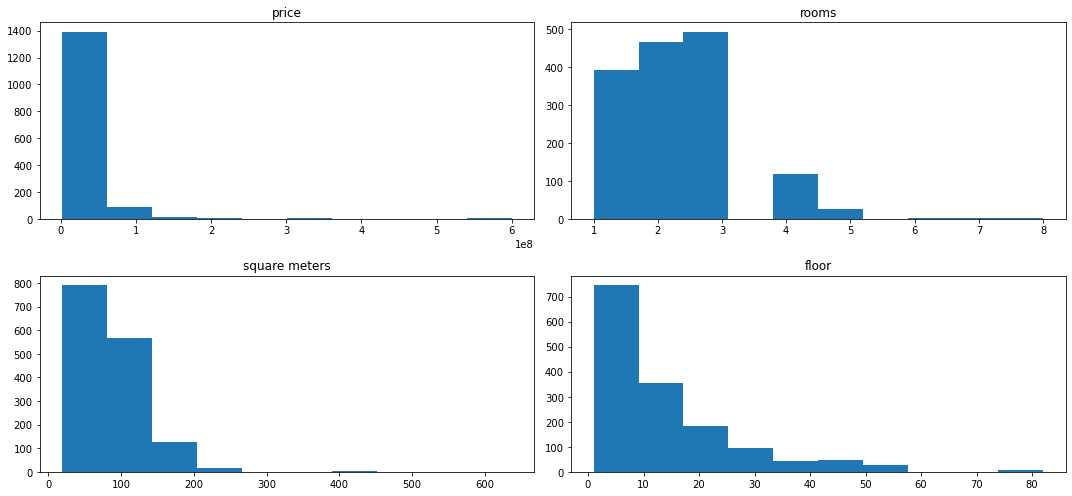

In [11]:
fig,ax=plt.subplots(2,2)
fig.set_size_inches(15,7)
plt.subplot(2,2,1)
plt.hist(apartments.price_ruble)
plt.title('price')
plt.subplot(2,2,2)
plt.hist(apartments.rooms)
plt.title('rooms')
plt.subplot(2,2,3)
plt.hist(apartments.sqr_meters)
plt.title('square meters')
plt.subplot(2,2,4)
plt.hist(apartments.floor)
plt.title('floor')
plt.tight_layout()

## Removing outliers 
Based on the histograms I've decided that an apartment that either has 6 or more room, is located on a floor higher than 69, is bigger than 500 square meters, or costs more than 200,000,000 rubles ($2.7 million) to be an outlier. After removing these observations our dataset went from a size of 1500 to 1484. 

In [12]:
print(len(apartments))
apartments=apartments[apartments.rooms<7]
apartments=apartments[apartments.floor<70]
apartments=apartments[apartments.sqr_meters<500]
apartments=apartments[apartments.price_ruble<200000000]
print(len(apartments))

1500
1484


## Checking the distribution of the data
After the removal of the outliers the distribution of the data looks a lot more normal. 

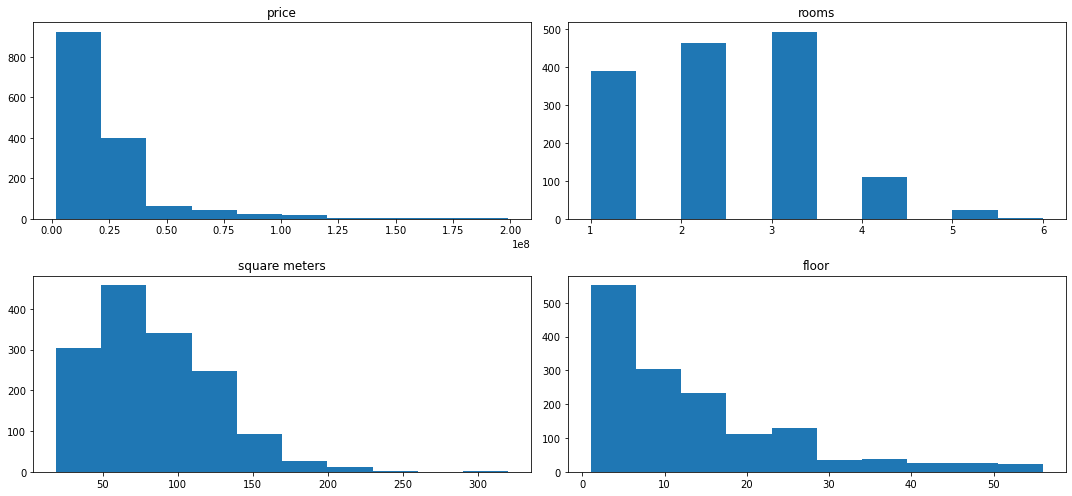

In [13]:
fig,ax=plt.subplots(2,2)
fig.set_size_inches(15,7)
plt.subplot(2,2,1)
plt.hist(apartments.price_ruble)
plt.title('price')
plt.subplot(2,2,2)
plt.hist(apartments.rooms)
plt.title('rooms')
plt.subplot(2,2,3)
plt.hist(apartments.sqr_meters)
plt.title('square meters')
plt.subplot(2,2,4)
plt.hist(apartments.floor)
plt.title('floor')
plt.tight_layout()

## New R2 score
The R2 incread to 0.875 after removing the outliers. 

In [14]:
X=apartments.loc[:,apartments.columns != 'price_ruble']
y=apartments['price_ruble']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                  test_size=0.1,
                                                  random_state=1)
reg = LinearRegression().fit(X, y) 
reg.score(X, y)

0.8749133438365437

## Sorting the metro stations
Based off off the coefficients from the regression I am able to rank the stations. With all other variables held constant my regression says Добрынинская is the most expensive and багратионовская is the cheapest. 

In [18]:
labels=X.columns
values=reg.coef_
metros=pd.DataFrame(values,index=labels)
metros.columns=['metro']
metros=metros.iloc[3:]
metros=metros.sort_values('metro',ascending=False)
print(metros.head(1))
print(metros.tail(1))

                     metro
Добрынинская  9.265433e+07
                        metro
Багратионовская -2.349638e+07


# Importing metro location data
From [apidata.mos.ru](https://apidata.mos.ru) I was able to load the GPS coordinates for each metro station

In [19]:
result=requests.get('https://apidata.mos.ru/v1/datasets/624/features?api_key=**************************')

200

## Unpacking the json data
Now I have a new dataframe that has the name of the metro station with it's GSP location

In [23]:
j=result.text
data=json.loads(j)
features=data['features']
locations=[]
names=[]
for station in features:
    locations.append(station['geometry']['coordinates'])
    names.append(station['properties']['Attributes']['Name'])
stations=pd.DataFrame({'geo':locations,'name':names})
for i,r in stations.iterrows():
    full_name=r[1]
    name=full_name.split(',')
    name=name[0]
    stations.iloc[i,1]=name
stations=stations.drop_duplicates(subset=['name'])
lat=[]
long=[]
for i,r in stations.iterrows():
    coor=str(r[0])
    coors=coor.split(',')
    coors[0]=coors[0].replace('[','')
    coors[1]=coors[1].replace(']','')
    lat.append(float(coors[0]))
    long.append(float(coors[1]))
stations['lat']=lat
stations['long']=long
stations=stations.drop('geo',axis=1)
stations.index=stations.name
stations=stations.drop('name',axis=1)
stations.head(2)

,lat,long
name,,
Китай-город,37.631677,55.757315
Калужская,37.539238,55.655386


## Joining the datasets
I've also made a new column called value. I divided the metro station into 4 groups based off of their coeifficents. The tops 25% will have a value of 1 and the bottom 25% will have a value of 4. 

In [24]:
final=metros.join(stations, how='inner')
final['value']=0
final.iloc[:33,3]=1
final.iloc[33:66,3]=2
final.iloc[66:99,3]=3
final.iloc[99:,3]=4

## Plotting the results
The metro stations that are closest to the center of Moscow are generally more expensive while the further from the center is cheaper.

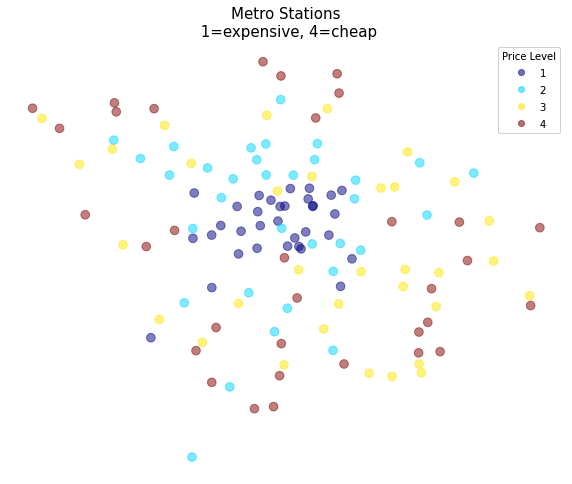

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(10,8)
scatter=ax.scatter(final.lat,final.long,s=75,c=final.value, cmap='jet',alpha=0.5)
legend1=ax.legend(*scatter.legend_elements(),
                 loc='upper right',title='Price Level')
ax.add_artist(legend1)
ax.set_title('Metro Stations\n 1=expensive, 4=cheap',size=15)
plt.axis('off')
plt.show()

## Closing remarks
Many metro stations have a small number observations. Indeed, not every metro station made it into the dataset. For this project to be more meaningful there needs to be a lot more data collected.  